# Predicting car prices

In this project, we will be using a K nearest neighbours model to predict the prices of cars from other attributes. We are connecting directly to a dataset in the first step. Additional documentation about the dataset we are using can be found here:
https://archive.ics.uci.edu/ml/datasets/automobile


In [1]:
import pandas as pd
import numpy as np


url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'

# No header on this dataset, so defining columns headings from the documentation.
cols = ['symboling','normalized_losses','make','fuel_type','aspiration','doors','body_style','drive_wheels',
       'engine_location','wheel_base','length','width','height','curb_weight','engine_type','cylinders','engine_size',
       'fuel_system','bore','stroke','compression_ratio','horsepower','peak_rpm','city_mpg','highway_mpg','price']

cars = pd.read_csv(url,header=None,names=cols)

In [2]:
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


# Normalizing and cleaning

We need to deal with missing values in numeric columns that we will use for our model, and also normalize columns so that no particular columns is given greater weight in the model.

In [3]:
# Replacing all '?' symbols with NaN
cars.replace(to_replace='?',value=np.nan,inplace=True)

In [4]:
cars.dtypes

symboling              int64
normalized_losses     object
make                  object
fuel_type             object
aspiration            object
doors                 object
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
cylinders             object
engine_size            int64
fuel_system           object
bore                  object
stroke                object
compression_ratio    float64
horsepower            object
peak_rpm              object
city_mpg               int64
highway_mpg            int64
price                 object
dtype: object

In [5]:
# Simple transform to float for columns with NaN
num_cols = ['normalized_losses','bore','stroke','horsepower','peak_rpm','price']
#cars[num_cols].isnull().sum()

cars[num_cols] = cars[num_cols].astype(float)

In [6]:
# Dictionary to map string versions of numbers to integers (for doors and cylinders)
str_nums = {'two':2,'three':3,'four':4,'five':5,'six':6,'eight':8,'twelve':12}

cars['doors'] = cars['doors'].map(str_nums)
cars['cylinders'] = cars['cylinders'].map(str_nums)

In [7]:
cars.dtypes

symboling              int64
normalized_losses    float64
make                  object
fuel_type             object
aspiration            object
doors                float64
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
cylinders              int64
engine_size            int64
fuel_system           object
bore                 float64
stroke               float64
compression_ratio    float64
horsepower           float64
peak_rpm             float64
city_mpg               int64
highway_mpg            int64
price                float64
dtype: object

In [8]:
# Looking better. Now to deal with null values.
cars.isnull().sum()

symboling             0
normalized_losses    41
make                  0
fuel_type             0
aspiration            0
doors                 2
body_style            0
drive_wheels          0
engine_location       0
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_type           0
cylinders             0
engine_size           0
fuel_system           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

In [9]:
# Vast majority of nulls are in the normalized_losses column, so that'll be the key one to deal with.
# Our dataset is small enough as it is, so I'm not keen to drop those rows. Instead I'll replace nulls
# with the average for the column.

cars['normalized_losses'] = cars['normalized_losses'].fillna(cars['normalized_losses'].mean())


In [10]:
# We'll be predicting price, so it'll be vital to have an accurate price value in our test set. For that reason, we'll drop
# rows with a null price.
cars = cars[cars['price'].isnull() == False]

In [11]:
# There is a complete overlap between null bore and null stroke rows, so we'll drop those too.
cars = cars[cars['bore'].isnull() == False]

In [12]:
# Similarly we'll drop the horsepower and peak_rpm nulls as they overlap
cars = cars[cars['horsepower'].isnull() == False]

In [13]:
# Both the null values in the doors column are on rows with the 'sedan' body type. Sedans are normally 4 door, so we'll
# use that value.
cars['doors'] = cars['doors'].fillna(4)

In [14]:
# Now we will normalize the numeric columns, so each has equal weight in the distance function

# Making a list of the numeric columns to normalize
numeric_cols = cars.select_dtypes(exclude=['object']).columns.tolist()

# Normalization equation: (value - value_mean) / value_standard_deviation 
normalized_cars = (cars[numeric_cols] - cars[numeric_cols].mean())/cars[numeric_cols].std()
normalized_cars['price'] = cars['price']
normalized_cars.head()

,symboling,normalized_losses,doors,wheel_base,length,width,height,curb_weight,cylinders,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,1.791895,0.017819,-1.183296,-1.679117,-0.437378,-0.837593,-2.111810,-0.020964,-0.407729,0.049755,0.517224,-1.815604,-0.294176,0.204073,-0.212456,-0.683346,-0.562432,13495.0
1,1.791895,0.017819,-1.183296,-1.679117,-0.437378,-0.837593,-2.111810,-0.020964,-0.407729,0.049755,0.517224,-1.815604,-0.294176,0.204073,-0.212456,-0.683346,-0.562432,16500.0
2,0.166688,0.017819,-1.183296,-0.716957,-0.245016,-0.181082,-0.609793,0.503130,1.555410,0.580721,-2.388623,0.699402,-0.294176,1.339545,-0.212456,-0.995779,-0.708860,16500.0
3,0.979292,1.320857,0.840763,0.147356,0.187800,0.147174,0.182938,-0.423086,-0.407729,-0.457076,-0.512697,0.476553,-0.047998,-0.033583,0.855301,-0.214697,-0.123149,13950.0
4,0.979292,1.320857,0.840763,0.082124,0.187800,0.240961,0.182938,0.505035,0.573840,0.194564,-0.512697,0.476553,-0.540353,0.309699,0.855301,-1.151995,-1.294570,17450.0


# Simple Univariate K Nearest Neighbours Modelling

We're going to start by looking at using one column at a time as a training column. We'll also start with a simple train/test split (no cross validation).

In [15]:
# We ought to randomize the order of the dataset first, so we can just cut the set in a straighforward manner later
# while still avoiding any bias based on the order of the dataset.

np.random.seed(1)
shuf_index = np.random.permutation(normalized_cars.index)
normalized_cars = normalized_cars.loc[shuf_index]

In [16]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import math

# Function to create our model.
def knn_train_test(k,df,train_col,target_col='price'):
    rows = df.shape[0]
    train_set = df[0:math.floor(rows * 0.75)]
    test_set = df[math.floor(rows * 0.75):]
    
    knn = KNeighborsRegressor(k,algorithm='auto')
    knn.fit(train_set[[train_col]],train_set[target_col])
    predictions = knn.predict(test_set[[train_col]])
    rmse = mean_squared_error(test_set[target_col],predictions)**(1/2)
    return rmse


In [26]:
# We will call the model function on each column in the normalized dataset individually.
cols = normalized_cars.columns.tolist()
cols.remove('price')

# We'll also iterate over a range of k values.
kvals = [1,3,5,7,9]

# We'll append results to a list
rmses = []
for c in cols:
    for ks in kvals:
        rmse = knn_train_test(ks,normalized_cars,c)
        # Results are a tuple with column name, k value and root mean squared value
        rmses.append((c,ks,rmse))

# Converting the results to a dataframe for ease of sorting/filtering/aggregating.
labels = ['column_name','k_value','rmse']
results = pd.DataFrame(rmses,columns=labels)

# We'll take a look at the top six columns, ranked by minimum rmse over all k values
top_6 = results[['column_name','rmse']].groupby('column_name').agg(min).sort_values('rmse').iloc[0:6]
top_6_names = top_6.index.tolist()
top_6

,rmse
column_name,
engine_size,2579.307153
wheel_base,2720.826870
length,2786.243730
horsepower,3101.559252
width,3349.996293
city_mpg,3585.938430


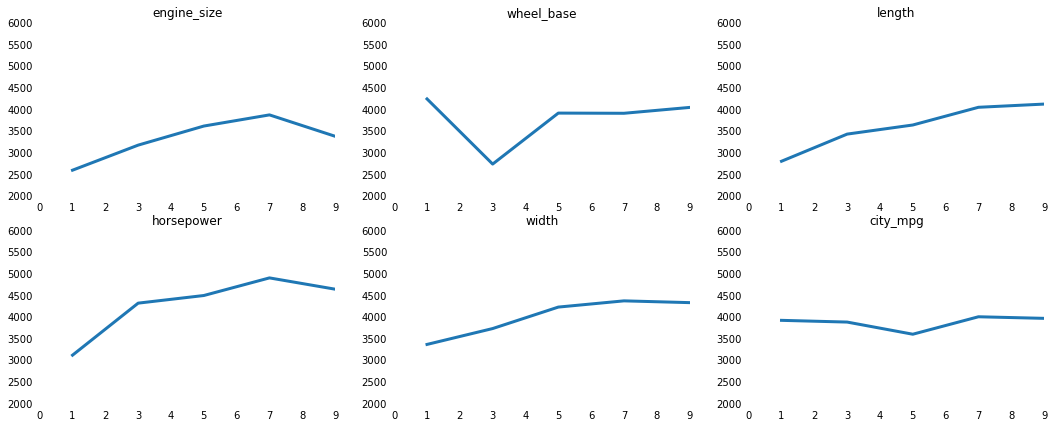

In [31]:
# Visualizing the top 6 columns over the range of k values.

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(18, 7))

for i,sp in enumerate(top_6_names):
    ax = fig.add_subplot(2,3,i+1)
    ax.plot(results[results['column_name']==sp]['k_value'], results[results['column_name']==sp]['rmse'], linewidth=3)
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)
    ax.set_xlim(0, 9)
    ax.set_ylim(2000,6000)
    ax.set_title(sp)
    ax.tick_params(bottom="off", top="off", left="off", right="off")

plt.show()

# Multivariate train/test

Increasing complexity by introducing multivariate models.

In [32]:
# Updating the model function so it accepts list parameters for the training columns.

def multi_knn_tt(k,df,train_cols,target_col='price'):
    rows = df.shape[0]
    train_set = df[0:math.floor(rows * 0.75)]
    test_set = df[math.floor(rows * 0.75):]
    
    knn = KNeighborsRegressor(k,algorithm='auto')
    knn.fit(train_set[train_cols],train_set[target_col])
    predictions = knn.predict(test_set[train_cols])
    rmse = mean_squared_error(test_set[target_col],predictions)**(1/2)
    return rmse

In [38]:
# We'll try modelling using combinations of the top performing univariate columns.
training_column_lists = [top_6_names[0:2],top_6_names[0:3],top_6_names[0:4],top_6_names[0:5],top_6_names]
titles = ['Best 2','Best_3','Best 4','Best 5','Best 6']

# New set of kvals to test over
kvals = [x for x in range(1,25)]

# We'll append results to a list
multi_rmses = []
for i,c in enumerate(training_column_lists):
    # kvals still defined from earlier
    for ks in kvals:
        rmse = multi_knn_tt(ks,normalized_cars,c)
        # Results are a tuple with column name, k value and root mean squared value
        multi_rmses.append((titles[i],ks,rmse))

# Converting the results to a dataframe for ease of sorting/filtering/aggregating.
labels = ['title','k_value','rmse']
multi_results = pd.DataFrame(multi_rmses,columns=labels)

multi_results[['title','rmse']].groupby('title').agg(min).sort_values('rmse').iloc[0:6]

,rmse
title,
Best 5,1845.631555
Best 6,1942.606848
Best_3,2604.902741
Best 4,2679.970963
Best 2,2968.405746


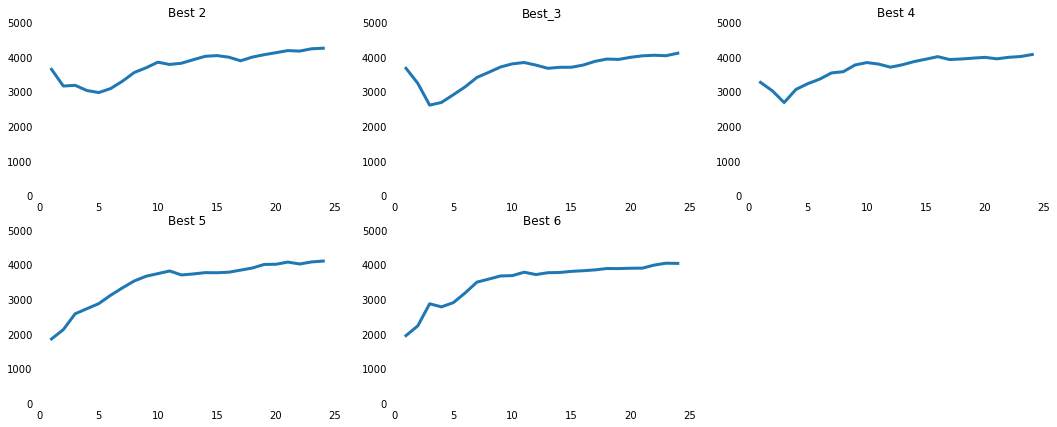

In [41]:
fig = plt.figure(figsize=(18, 7))

for i,sp in enumerate(titles):
    ax = fig.add_subplot(2,3,i+1)
    ax.plot(multi_results[multi_results['title']==sp]['k_value'], multi_results[multi_results['title']==sp]['rmse'], linewidth=3)
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)
    ax.set_xlim(0, 25)
    ax.set_ylim(0,5000)
    ax.set_title(sp)
    ax.tick_params(bottom="off", top="off", left="off", right="off")

plt.show()

The best performing models we have so far are those using the best 5 and best 6 performing columns under univariate conditions. These are (in order): engine_size, wheel_base, length, horsepower, width and lastly city_mpg.
Interestingly, both these models performed best with only 1 nearest neighbour.

In [ ]:
# Next steps:
# Adjust method to use cross validation.